<a href="https://colab.research.google.com/github/YasinnSoylu/LSTM_CNN_STOCK/blob/main/LSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline
plt.style.use("ggplot")


In [ ]:
symbol = 'THYAO.IS'
start_date = '2012-01-01'
end_date = '2022-01-01'
data = yf.download(symbol, start=start_date, end=end_date)
df = pd.DataFrame(data)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,1.869565,1.904347,1.843478,1.869565,1.838887,8346064
2012-01-03,1.921739,1.930434,1.878260,1.921739,1.890205,14905536
2012-01-04,1.869565,1.930434,1.852173,1.869565,1.838887,12923838
2012-01-05,1.834782,1.878260,1.817391,1.834782,1.804675,13952080
2012-01-06,1.791304,1.852173,1.773913,1.791304,1.761910,13945201


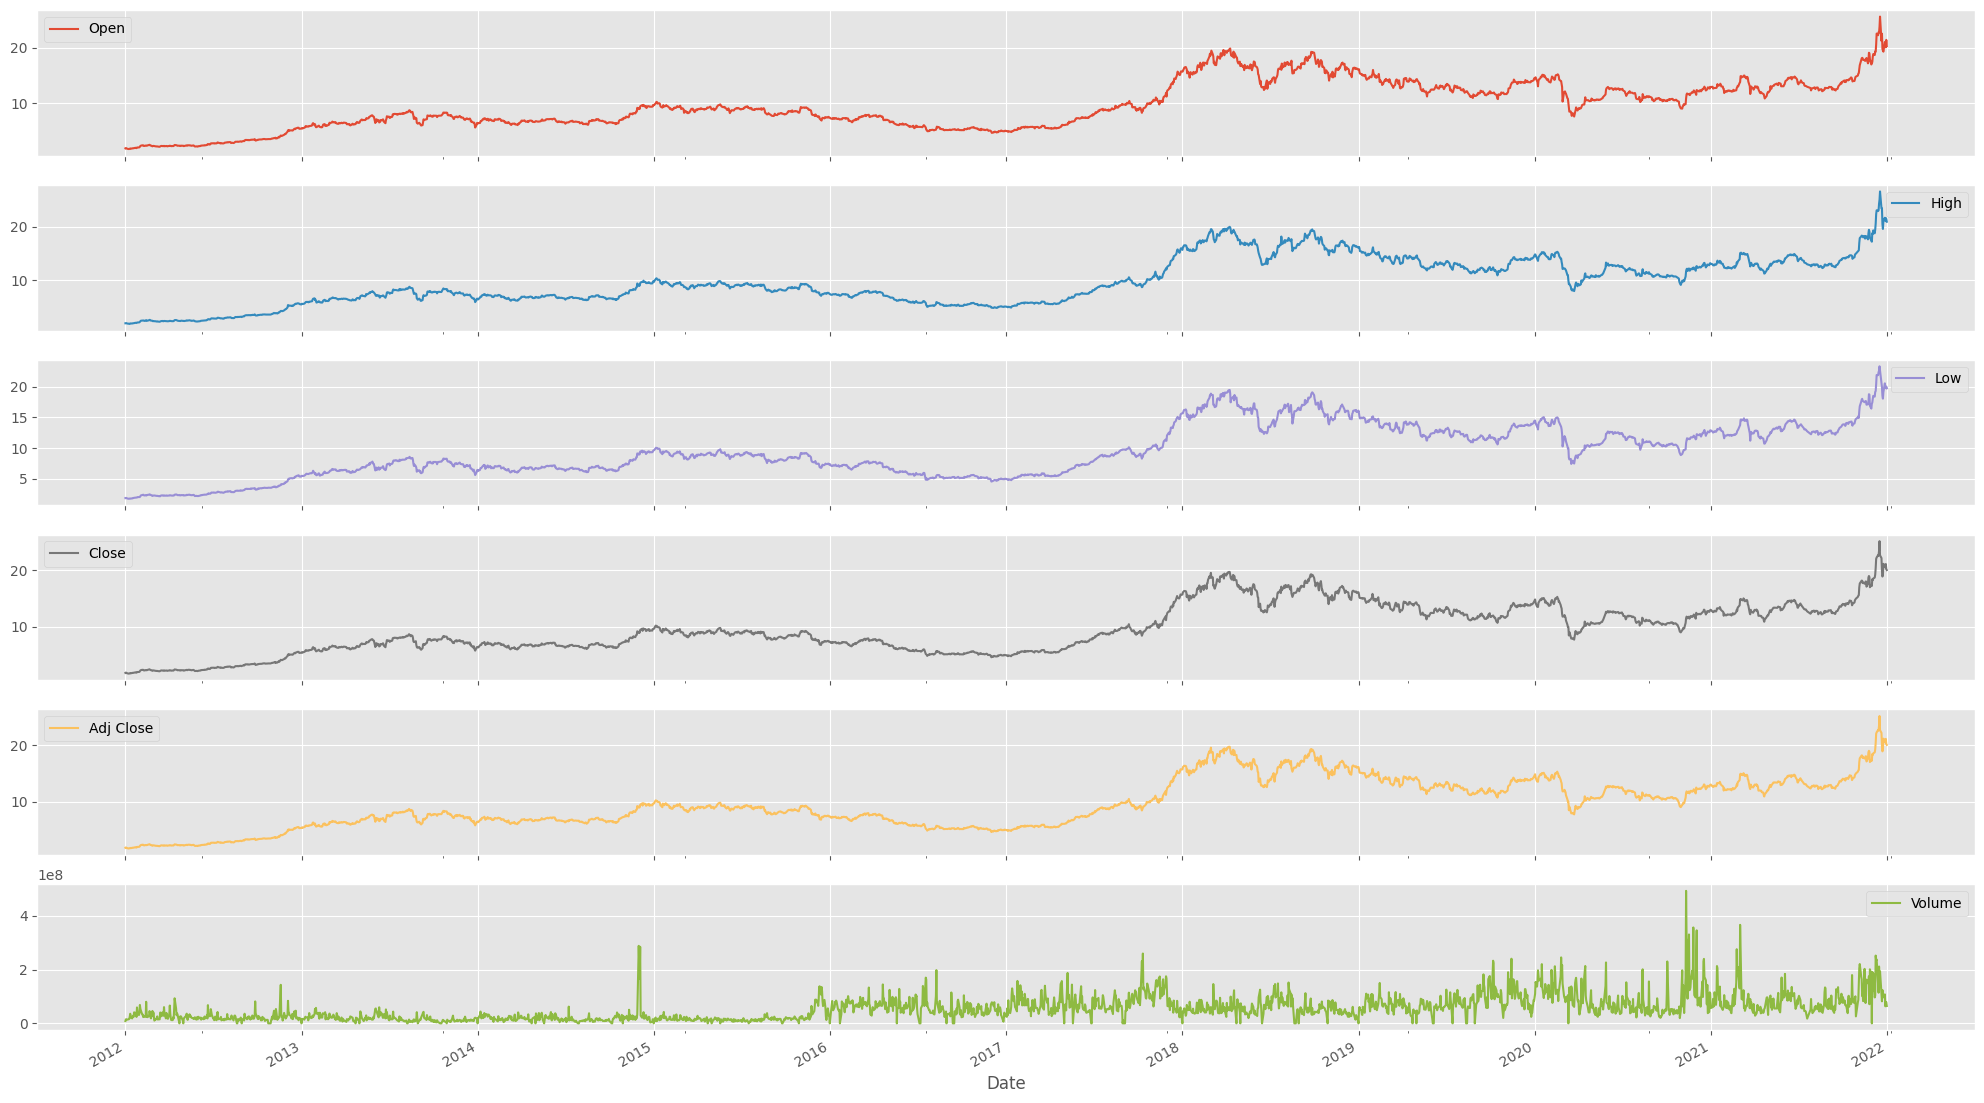

In [ ]:
data.plot(legend=True,subplots=True, figsize = (25, 15))
plt.show()

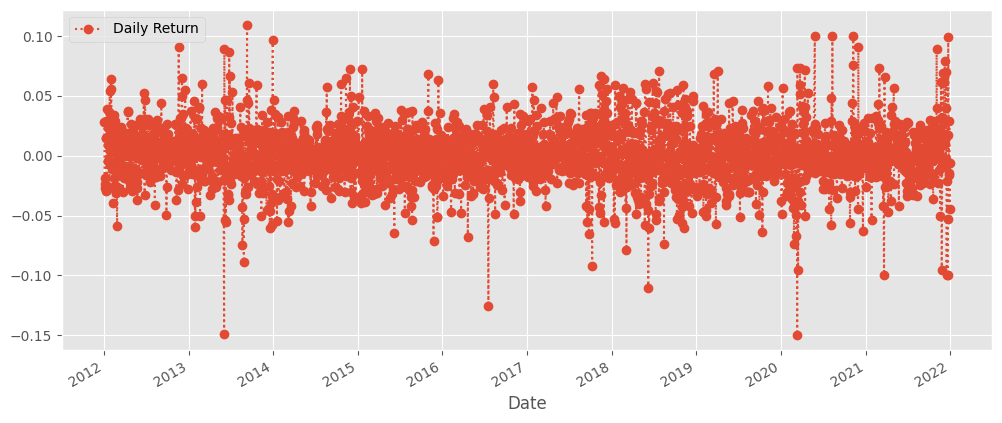

In [ ]:
data['Daily Return'] = data['Close'].pct_change()
# plot the daily return percentage
data['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=60
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(60, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,60,1)
test_X = test_X.reshape(test_X.shape[0],1,60,1)

print(len(train_X))
print(len(test_X))

2020
505


In [ ]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError



In [ ]:
model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 60, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(60, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(60, return_sequences=False)))
model.add(Dropout(0.5))



In [ ]:
#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [ ]:

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=100,batch_size=256, verbose=1,callbacks=[callback])

Epoch 1/100
8/8 [==============================] - 13s 251ms/step - loss: 0.1405 - mse: 0.0478 - val_loss: 0.1226 - val_mse: 0.0390
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1140 - mse: 0.0368 - val_loss: 0.0933 - val_mse: 0.0239
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0836 - mse: 0.0194 - val_loss: 0.0721 - val_mse: 0.0144
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0674 - mse: 0.0143 - val_loss: 0.0586 - val_mse: 0.0111
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0560 - mse: 0.0123 - val_loss: 0.0495 - val_mse: 0.0105
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0475 - mse: 0.0115 - val_loss: 0.0418 - val_mse: 0.0097
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0400 - mse: 0.0107 - val_loss: 0.0356 - val_mse: 0.0095
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0338 - mse: 0.

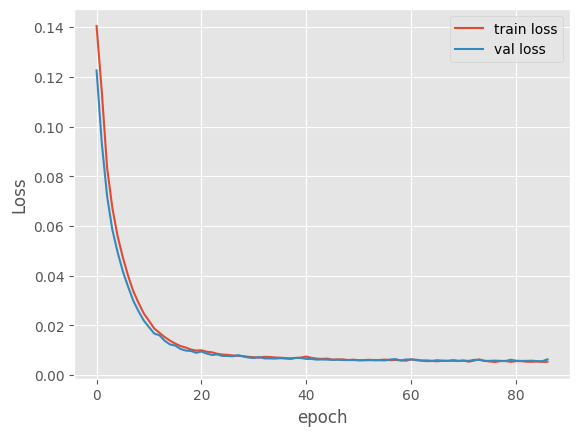

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
model.evaluate(test_X, test_Y)

16/16 [==============================] - 0s 9ms/step - loss: 0.0063 - mse: 0.0060


[0.006345825269818306, 0.006008399650454521]

In [ ]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.868781
R2 Score: 0.868781
Max Error: 0.356654


# testing

In [ ]:
start_date_test = '2022-01-01'
end_date_test = '2023-04-25'
test_data = yf.download(symbol, start=start_date_test, end=end_date_test)
df= pd.DataFrame(test_data)





[*********************100%***********************]  1 of 1 completed


In [ ]:
X = []
Y = []
window_size = 60

for i in range(1, len(df) - window_size - 1):
    first = df.iloc[i, 4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 4] - first) / first)
    temp2.append((df.iloc[i + window_size, 4] - first) / first)
    X.append(np.array(temp).reshape(60, 1))
    Y.append(np.array(temp2).reshape(1, 1))

test_X = np.array(X)
test_Y = np.array(Y)

test_X = test_X.reshape(test_X.shape[0], 1, 60, 1)
test_Y = test_Y.reshape(test_Y.shape[0], 1)



9/9 [==============================] - 0s 12ms/step


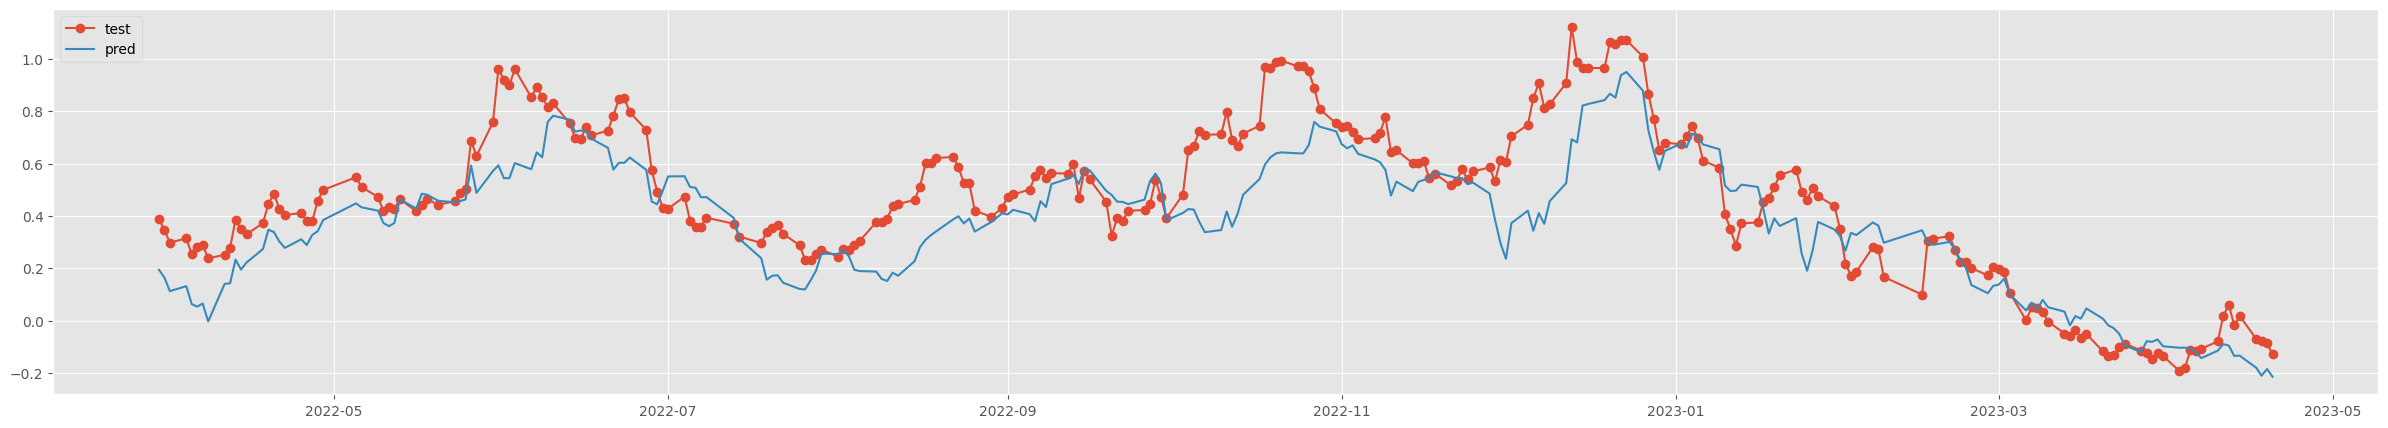

In [ ]:

predicted = model.predict(test_X)

predicted = np.array(predicted[:,0]).reshape(-1,1)



import matplotlib.pyplot as plt

results = pd.DataFrame({'test': test_Y[:, 0], 'pred': predicted[:, 0]}, index=df.iloc[-len(test_Y):].index)
plt.figure(figsize=(30,5))
plt.plot(results['test'], label='test',marker="o")
plt.plot(results['pred'], label='pred')
plt.legend(loc='upper left')
plt.show()